In [26]:
import sys
GIT_SRC = "C:\\Users\\salom\\Documents\\code\\KTH\\KEX---CT-reconstruction\\src"
if not GIT_SRC in sys.path:
    sys.path.append(GIT_SRC)

import torch
import torch.nn as nn

import odl
import odl.contrib.torch as odl_torch

import numpy as np

from utils.geometry import Geometry, DEVICE, extend_geometry
from utils.moments import SinoMoments

from models.expnet import MomentFiller

geom = Geometry(0.5, 450, 300)
print(geom)
ext_geom = extend_geometry(geom)
n_moments = 12
smp = SinoMoments(ext_geom, n_moments=n_moments)
print(smp)

mse_fn = lambda diff : torch.mean(diff**2)
n_phantoms = 50
read_data: torch.Tensor = torch.load("C:/Users/salom/Documents/code/KTH/KEX---CT-reconstruction/data/kits_phantoms_256.pt").moveaxis(0,1).to(DEVICE)
read_data = torch.concat([read_data[1], read_data[0], read_data[2]])
read_data = read_data[:n_phantoms]
read_data /= torch.max(torch.max(read_data, dim=-1).values, dim=-1).values[:, None, None]
phantoms = read_data

ray_l = odl_torch.OperatorModule(geom.ray)
ext_ray_l = odl_torch.OperatorModule(ext_geom.ray)

sinos = ray_l(phantoms)
full_sinos = ext_ray_l(phantoms)

MOMS_GT = [smp.get_moment(full_sinos, ni) for ni in range(n_moments)]
PROJ_MOMS_GT = [smp.project_moment(mom, ni) for ni, mom in enumerate(MOMS_GT)]
MOMS_MSE_GT  = sum(mse_fn(p_mom-mom) for p_mom, mom in zip(MOMS_GT, PROJ_MOMS_GT))
print("GT mom mse: ", MOMS_MSE_GT.item())

mfiller = MomentFiller(smp, max_iters=500, verbose=True)

pepper = mfiller(sinos)
exp_sinos = torch.concat([sinos, pepper], dim=1)

print(f"Sino mse {mse_fn(exp_sinos-full_sinos).item()}")

Geometry(
            angle ratio: 0.5 phi_size: 450 t_size: 300
            reco_space: uniform_discr([-1., -1.], [ 1.,  1.], (256, 256), dtype='float32')
        )

            SinoMoments(
                n_moments=12
                geometry=Geometry(
            angle ratio: 1.0 phi_size: 900 t_size: 300
            reco_space: uniform_discr([-1., -1.], [ 1.,  1.], (256, 256), dtype='float32')
        )
            )
        
GT mom mse:  0.0006375319208018482
sinos analytically extrapolated with moment diff 0.12318292260169983 after 500 iterations.
Sino mse 0.011098088696599007


In [28]:
print(f"Sino mse {mse_fn(exp_sinos-full_sinos).item()}")

Sino mse 0.011098088696599007


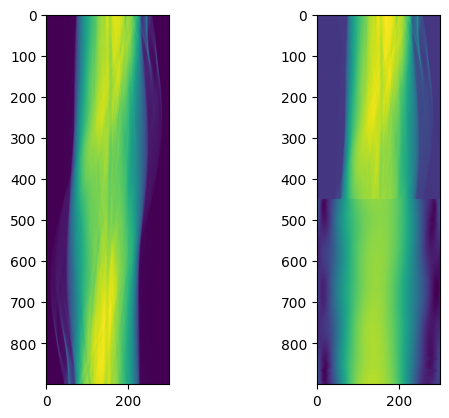

In [29]:
import matplotlib.pyplot as plt

plt.subplot(121)
plt.imshow(full_sinos[30].cpu())
plt.subplot(122)
plt.imshow(exp_sinos[30].cpu())

plt.show()

In [32]:
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

compensator = nn.Sequential(
    nn.Conv2d(1, 32, (5,5), padding="same"),
    nn.GELU(),
    nn.Conv2d(32, 8, (5,5), padding="same"),
    nn.GELU(),
    nn.Conv2d(8, 1, (5,5), padding="same")
)
correlator = nn.Sequential(
    nn.Conv2d(1, 16, (5,5), padding="same"),
    nn.GELU(),
    nn.Conv2d(16, 4, (5,5), padding="same"),
    nn.GELU(),
    nn.Conv2d(4, 1, (5,5), padding="same")
)
optimizer = torch.optim.Adam(compensator.parameters(), lr=0.0001)

n_fixed = geom.phi_size

train_dataset = TensorDataset(exp_sinos[:30], full_sinos[:30])
test_X, test_Y = exp_sinos[30:], full_sinos[30:]
dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)

N_epochs = 60
mse_fn = lambda diff : torch.mean(diff**2)
        

for epoch in range(N_epochs):
    batch_losses = []
    for X, Y in dataloader:
        optimizer.zero_grad()

        filler = X[:, n_fixed:]
        new_filler = compensator(X[:, None])[:, 0, n_fixed:]
        #corr_filler = correlator(torch.flip(X, (1,))[:, None])[:, 0, n_fixed:]

        out = F.relu(torch.concat([X[:, :n_fixed], new_filler + filler], dim=1))

        loss = mse_fn(Y - out)

        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss.item())

    print(f"Epoch {epoch} mse is {np.mean(batch_losses)}")


test_filler = compensator(test_X[:, None])[:, 0, n_fixed:]
#test_corr_filler = correlator(torch.flip(test_X, (1,))[:, None])[:, 0, n_fixed:]
test_out = F.relu(torch.concat([test_X[:, :n_fixed], test_filler + test_X[:, n_fixed:]], dim=1))

print("Final mse test", mse_fn(test_out - test_Y).item())




Epoch 0 mse is 0.2091469665368398
Epoch 1 mse is 0.17950334151585898
Epoch 2 mse is 0.14996642371018729
Epoch 3 mse is 0.12175076206525166
Epoch 4 mse is 0.09521458794673283
Epoch 5 mse is 0.0688352460662524
Epoch 6 mse is 0.04569439465800921
Epoch 7 mse is 0.02801925813158353
Epoch 8 mse is 0.016703156754374504
Epoch 9 mse is 0.011985304454962412
Epoch 10 mse is 0.012792037799954414
Epoch 11 mse is 0.015337456638614336
Epoch 12 mse is 0.01641494408249855
Epoch 13 mse is 0.015058119470874468
Epoch 14 mse is 0.012580543446044127
Epoch 15 mse is 0.010567186089853445
Epoch 16 mse is 0.009621841522554556
Epoch 17 mse is 0.009493204765021801
Epoch 18 mse is 0.0096428490554293
Epoch 19 mse is 0.009615538020928701
Epoch 20 mse is 0.009309953078627586
Epoch 21 mse is 0.008847320762773355
Epoch 22 mse is 0.008424698375165462
Epoch 23 mse is 0.008160428299258152
Epoch 24 mse is 0.0079963942989707
Epoch 25 mse is 0.00786714581772685
Epoch 26 mse is 0.00770354022582372
Epoch 27 mse is 0.0075104188

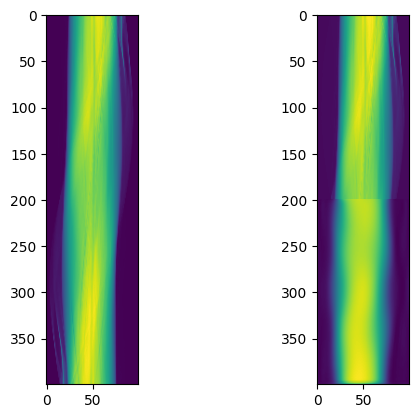

In [27]:
import matplotlib.pyplot as plt

plt.subplot(121)
plt.imshow(test_Y[0].cpu())
plt.subplot(122)
plt.imshow(test_out[0].detach().cpu())